<a href="https://colab.research.google.com/github/zhuofachen/Spec_Classification/blob/main/CNN_Benchmarks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
import random
import collections

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
seed = 42
np.random.seed(seed)
random.seed(seed)
# os.environ['PYTHONHASHSEED'] = str(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Dataset

In [ ]:
def load_file(filename):
    file = open(filename) 

    lines = file.readlines()
        
    data = []
    for line in lines:
        arr = []
        for num in line.split(","):
            arr.append(float(num))
        data.append(arr)

    return np.array(data)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, spectra, labels, augmentation=None):
        self.spectra = spectra
        self.labels = labels
        self.augmentation = augmentation

    def __len__(self):
        return len(self.spectra)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        spec = self.spectra[idx].reshape(1, -1)
        max_Intensity = np.max(spec, axis = 1)
        if self.augmentation:
            
            if random.uniform(0, 1) > 0.5: # noise
                noise = np.random.normal(0, max_Intensity/40, spec.shape[1]).astype(np.float32)
                spec = spec + noise
            
            # if random.uniform(0, 1) > 0.5: # dropout
            #     indices = np.random.choice(np.arange(spec.size), replace=False, size=int(spec.size * 0.2))
            #     spec[:, indices] = 0
            
            if random.uniform(0, 1) > 0.5:   # Shift
                temp = np.zeros(spec.shape).astype(np.float32)
                shift_count = np.random.randint(1, 30)
            
                if random.uniform(0, 1) > 0.5:   # Shift right
                    temp[:, shift_count:] = spec[:, :-shift_count]
                else:
                    temp[:, :-shift_count] = spec[:, shift_count:]
                
                spec = temp

        label = torch.tensor(self.labels[idx]).type(torch.long)
        spec = spec.astype(np.float32)
        sample = (spec/max_Intensity, label)

        return sample

In [ ]:
# Load data
Y = []
data = []
# path = 'datasets/dielectric_dataset/'
# for i in range(4):
#     curr_data = load_file(path + "dielectric" + str(i) + ".txt")    
#     data.append(curr_data)
#     count = len(curr_data)
#     Y.extend([i] * count)

path = 'datasets/charge_dataset/'
for i in range(4):
    curr_data = load_file(path + "c" + str(i) + ".txt")    
    data.append(curr_data)
    count = len(curr_data)
    Y.extend([i] * count)

X = np.vstack(data)
Y = np.array(Y)
count = collections.defaultdict(int)
for num in Y:
    count[num] += 1
classes_count = len(count.keys())

for i in sorted(count.keys()):
    print("Class", i, "Count:", count[i])

Class 0 Count: 1355
Class 1 Count: 1386
Class 2 Count: 727
Class 3 Count: 951


In [ ]:
# Split data into train, val, & test sets
xtrain, xval, ytrain, yval = train_test_split(X, Y, stratify=Y, train_size=0.8, random_state=seed, shuffle=True)

print("X shape:\t", X.shape)
print("xtrain shape:\t", xtrain.shape)
print("xval shape:\t", xval.shape)
print("Y shape:\t", Y.shape)
print("ytrain shape:\t", ytrain.shape)
print("yval shape:\t", yval.shape)

X shape:	 (4419, 728)
xtrain shape:	 (3535, 728)
xval shape:	 (884, 728)

Y shape:	 (4419,)
ytrain shape:	 (3535,)
yval shape:	 (884,)


# Models

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv1d(1, 2, 9, 1)  
        self.conv2 = nn.Conv1d(2, 2, 7, 1)  
        self.conv3 = nn.Conv1d(2, 4, 7, 1)  
        self.conv4 = nn.Conv1d(4, 8, 5, 1)
        self.conv5 = nn.Conv1d(8, 12, 3, 1)

        self.bn1 = nn.BatchNorm1d(2)
        self.bn2 = nn.BatchNorm1d(2)
        self.bn3 = nn.BatchNorm1d(4)
        self.bn4 = nn.BatchNorm1d(8)
        self.bn5 = nn.BatchNorm1d(12)

        self.fc1 = nn.Linear(12 * 19, 128)
        self.fc2 = nn.Linear(128, classes_count)   
        self.pool = nn.AvgPool1d(2)

        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.pool(self.bn1(F.relu(self.conv1(x))))
        x = self.pool(self.bn2(F.relu(self.conv2(x))))
        x = self.pool(self.bn3(F.relu(self.conv3(x))))
        x = self.pool(self.bn4(F.relu(self.conv4(x))))
        x = self.pool(self.bn5(F.relu(self.conv5(x))))
        
        x = x.view(-1, 12 * 19)      
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.softmax(x)  
        
        return x

    def embed(self, x):
        x = self.pool(self.bn1(F.relu(self.conv1(x))))
        x = self.pool(self.bn2(F.relu(self.conv2(x))))
        x = self.pool(self.bn3(F.relu(self.conv3(x))))
        x = self.pool(self.bn4(F.relu(self.conv4(x))))
        x = self.pool(self.bn5(F.relu(self.conv5(x))))
        x = x.view(-1, 12 * 22)
        x = F.relu(self.fc1(x))
        
        return x

In [ ]:
class FullCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv1d(1, 2, 9, 1)  
        self.conv2 = nn.Conv1d(2, 2, 7, 1)  
        self.conv3 = nn.Conv1d(2, 4, 7, 1)  
        self.conv4 = nn.Conv1d(4, 8, 5, 1)
        self.conv5 = nn.Conv1d(8, 12, 3, 1)

        self.conv6 = nn.Conv1d(12, classes_count, 1, 1)
        self.gap = nn.AvgPool2d((1, 19))

        self.bn1 = nn.BatchNorm1d(2)
        self.bn2 = nn.BatchNorm1d(2)
        self.bn3 = nn.BatchNorm1d(4)
        self.bn4 = nn.BatchNorm1d(8)
        self.bn5 = nn.BatchNorm1d(12)
        self.bn6 = nn.BatchNorm1d(classes_count)

        self.fc1 = nn.Linear(12 * 19, classes_count)           
        self.pool = nn.AvgPool1d(2)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        
        x = self.pool(self.bn1(F.relu(self.conv1(x))))
        x = self.pool(self.bn2(F.relu(self.conv2(x))))
        x = self.pool(self.bn3(F.relu(self.conv3(x))))
        x = self.pool(self.bn4(F.relu(self.conv4(x))))
        x = self.pool(self.bn5(F.relu(self.conv5(x))))
        x = self.bn6(F.relu(self.conv6(x)))
        x = self.gap(x)        
        x = x.view(-1, classes_count)
        x = self.softmax(x)  
        
        return x

In [ ]:
class MultiHead(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.conv1a = nn.Conv1d(1, 8, 3, 1)  
        self.conv2a = nn.Conv1d(1, 8, 5, 1)  
        self.conv3a = nn.Conv1d(1, 8, 7, 1)

        self.conv1b = nn.Conv1d(8, 4, 3, 1)  
        self.conv2b = nn.Conv1d(8, 4, 5, 1)  
        self.conv3b = nn.Conv1d(8, 4, 7, 1)

        self.drop = nn.Dropout(0.001)
        self.pool = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(2144, classes_count)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):

        x1 = self.pool(self.drop(F.relu(self.conv1a(x))))
        x2 = self.pool(self.drop(F.relu(self.conv2a(x))))
        x3 = self.pool(self.drop(F.relu(self.conv3a(x))))
        x1 = self.pool(self.drop(F.relu(self.conv1b(x1))))
        x2 = self.pool(self.drop(F.relu(self.conv2b(x2))))
        x3 = self.pool(self.drop(F.relu(self.conv3b(x3))))
        x1 = x1.view(-1, 4 * 180)
        x2 = x2.view(-1, 4 * 179)
        x3 = x3.view(-1, 4 * 177)
    
        x = torch.cat((x1, x2, x3), dim=1)

        x = F.relu(self.fc1(x))
        
        x = self.softmax(x.view(-1, classes_count))

        return x

In [ ]:
class Dense(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(728, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 16)
        self.fc7 = nn.Linear(16, classes_count)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = self.softmax(x.view(-1, classes_count))

        return x

# Training and Evaluation Loops

In [ ]:
def train(net, dataloader, criterion, optimizer):
    net = net.train()   
    loss_tr, correct_count, n_samples = 0.0, 0.0, 0.0
    for i, data in enumerate(dataloader):
        inputs, labels = data
        inputs, labels = inputs.float().to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # calculate performance metrics
        loss_tr += loss.item()
        _, preds = torch.max(outputs.data, 1)
        correct_count += (preds == labels).sum().item()
        n_samples += labels.size(0)

    acc = 100 * correct_count / n_samples
    loss = loss_tr / n_samples

    return acc, loss

In [ ]:
def evaluate(net, dataloader, criterion):
    with torch.no_grad():  # remove gradient calculation, by default, in evaluation mode, torch will still calculate gradient. 
        net = net.eval()
        loss_tr, correct_count, n_samples, preds = 0.0, 0.0, 0.0, []
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.float().to(device), labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            # calculate performance metrics
            loss_tr += loss.item()
            _, pred = torch.max(outputs.data, 1)
            preds.extend([p.item() for p in pred])
            correct_count += (pred == labels).sum().item()
            n_samples += labels.size(0)

        acc = 100 * correct_count / n_samples
        loss = loss_tr / n_samples

    return acc, loss, preds

In [ ]:
def get_all_acc(net, dataloader, criterion):

    confusion_matrix = torch.zeros(classes_count, classes_count)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(dataloader):
            inputs = inputs.float().to(device)
            classes = classes.to(device)           
            outputs = net(inputs)           
            _, preds = torch.max(outputs.data, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1

    per_class_acc = confusion_matrix.diag()/confusion_matrix.sum(1)
    aggregate_acc = confusion_matrix.diag().sum() / confusion_matrix.sum()

    return [num.item() for num in (aggregate_acc, *per_class_acc)]

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

def run(model):
    # Setup 
    
    model = model.float().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=hps['lr'])
    best_accuracy = 0
    for epoch in range(hps['epochs']):
        # pass through train and val dataloaders
        acc_tr, loss_tr = train(model, trainloader, criterion, optimizer)
        acc_v, loss_v, preds = evaluate(model, valloader, criterion)
        
        if acc_v > best_accuracy:
            best_accuracy = acc_v
            torch.save(model.state_dict(), "best_params")
        if best_accuracy == 100:
            break

    model.load_state_dict(torch.load("best_params"))
    
    return model


# CNN

In [ ]:
# Hyperparameters
hps = {
    'bs': 64,
    'epochs': 100,
    'lr': 0.001,
    'augment': False,
}

In [ ]:
# Build pytorch Datasets and Dataloaders
data_train = CustomDataset(xtrain, ytrain, augmentation=hps['augment'])
data_val = CustomDataset(xval, yval)

trainloader = DataLoader(data_train, batch_size=hps['bs'], shuffle=True, num_workers=2)
valloader = DataLoader(data_val, batch_size=hps['bs'], shuffle=False, num_workers=2)

accs = []

# setup progress bar
pbar = tqdm(range(50))

for i in pbar:
    model = run(CNN())
    all_acc = get_all_acc(model, valloader, criterion)
    accs.append(all_acc)

accs = np.array(accs)

100%|██████████| 50/50 [1:01:30<00:00, 73.82s/it]


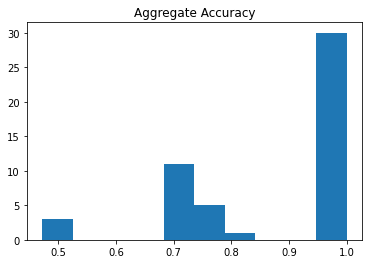

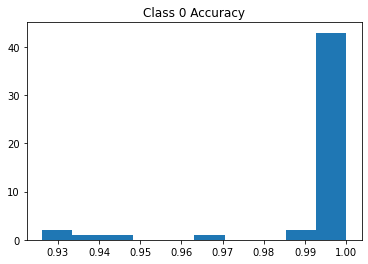

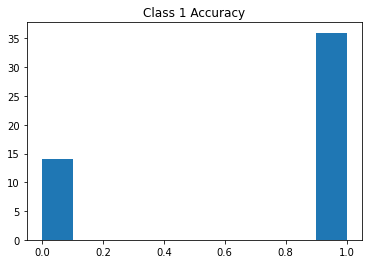

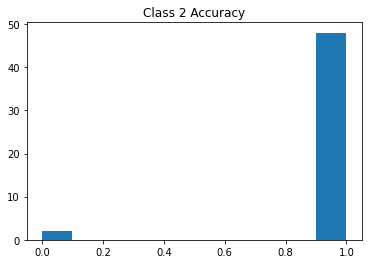

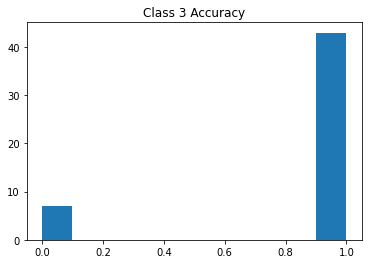

In [ ]:
plt.figure()
plt.hist(accs[:, 0])
plt.title("Aggregate Accuracy")
plt.show()

plt.figure()
plt.hist(accs[:, 1])
plt.title("Class 0 Accuracy")
plt.show()

plt.figure()
plt.hist(accs[:, 2])
plt.title("Class 1 Accuracy")
plt.show()

plt.figure()
plt.hist(accs[:, 3])
plt.title("Class 2 Accuracy")
plt.show()

plt.figure()
plt.hist(accs[:, 4])
plt.title("Class 3 Accuracy")
plt.show()

# Full CNN

In [ ]:
# Hyperparameters
hps = {
    'bs': 16,
    'epochs': 100,
    'lr': 0.001,
    'augment': False,
}

In [ ]:
# Build pytorch Datasets and Dataloaders
data_train = CustomDataset(xtrain, ytrain, augmentation=hps['augment'])
data_val = CustomDataset(xval, yval)

trainloader = DataLoader(data_train, batch_size=hps['bs'], shuffle=True, num_workers=2)
valloader = DataLoader(data_val, batch_size=hps['bs'], shuffle=False, num_workers=2)
accs = []
# setup progress bar
pbar = tqdm(range(50))

for i in pbar:
    model = run(FullCNN())
    all_acc = get_all_acc(model, valloader, criterion)
    accs.append(all_acc)

accs = np.array(accs)

100%|██████████| 50/50 [3:17:59<00:00, 237.59s/it]


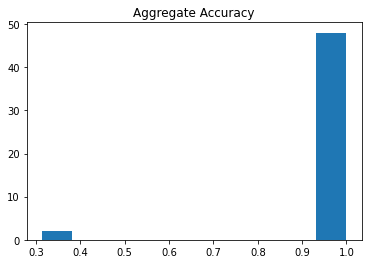

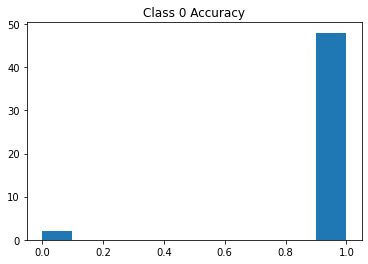

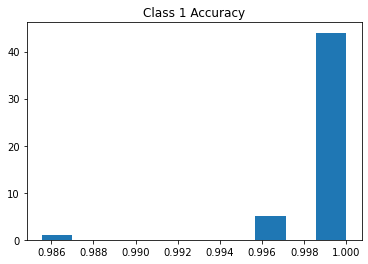

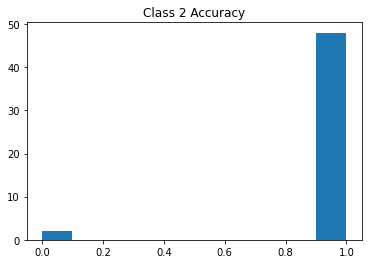

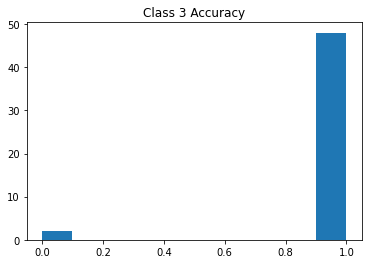

In [ ]:
plt.figure()
plt.hist(accs[:, 0])
plt.title("Aggregate Accuracy")
plt.show()

plt.figure()
plt.hist(accs[:, 1])
plt.title("Class 0 Accuracy")
plt.show()

plt.figure()
plt.hist(accs[:, 2])
plt.title("Class 1 Accuracy")
plt.show()

plt.figure()
plt.hist(accs[:, 3])
plt.title("Class 2 Accuracy")
plt.show()

plt.figure()
plt.hist(accs[:, 4])
plt.title("Class 3 Accuracy")
plt.show()

# MultiHead CNN

In [ ]:
# Hyperparameters
hps = {
    'bs': 128,
    'epochs': 100,
    'lr': 0.001,
    'augment': False,
}

In [ ]:
# Build pytorch Datasets and Dataloaders
data_train = CustomDataset(xtrain, ytrain, augmentation=hps['augment'])
data_val = CustomDataset(xval, yval)
trainloader = DataLoader(data_train, batch_size=hps['bs'], shuffle=True, num_workers=2)
valloader = DataLoader(data_val, batch_size=hps['bs'], shuffle=False, num_workers=2)
accs = []
# setup progress bar
pbar = tqdm(range(50))

for i in pbar:
    model = run(MultiHead())
    all_acc = get_all_acc(model, valloader, criterion)
    accs.append(all_acc)

accs = np.array(accs)

100%|██████████| 50/50 [47:23<00:00, 56.87s/it]


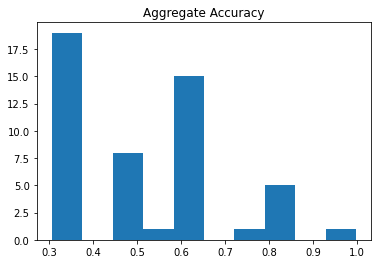

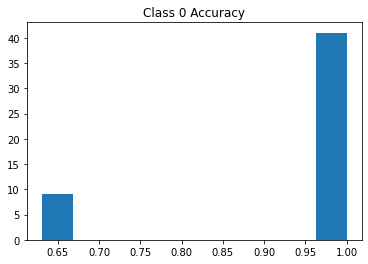

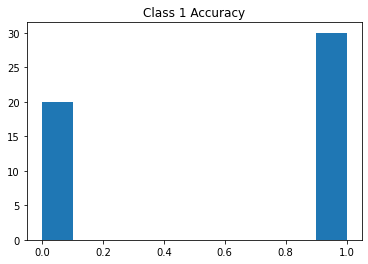

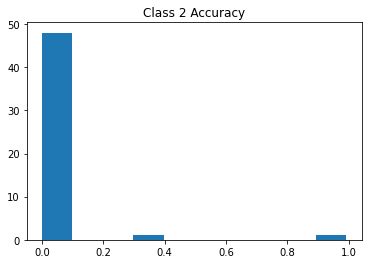

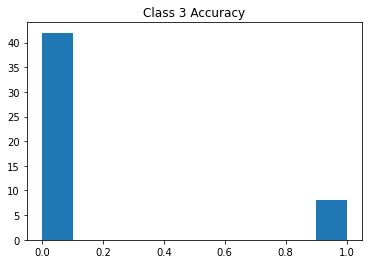

In [ ]:
plt.figure()
plt.hist(accs[:, 0])
plt.title("Aggregate Accuracy")
plt.show()

plt.figure()
plt.hist(accs[:, 1])
plt.title("Class 0 Accuracy")
plt.show()

plt.figure()
plt.hist(accs[:, 2])
plt.title("Class 1 Accuracy")
plt.show()

plt.figure()
plt.hist(accs[:, 3])
plt.title("Class 2 Accuracy")
plt.show()

plt.figure()
plt.hist(accs[:, 4])
plt.title("Class 3 Accuracy")
plt.show()

# Dense 

In [ ]:
# Hyperparameters
hps = {
    'bs': 64,
    'epochs': 100,
    'lr': 0.001,
    'augment': False,
}

In [ ]:
# Build pytorch Datasets and Dataloaders
data_train = CustomDataset(xtrain, ytrain, augmentation=hps['augment'])
data_val = CustomDataset(xval, yval)

trainloader = DataLoader(data_train, batch_size=hps['bs'], shuffle=True, num_workers=2)
valloader = DataLoader(data_val, batch_size=hps['bs'], shuffle=False, num_workers=2)

accs = []

# setup progress bar
pbar = tqdm(range(50))

for i in pbar:
    model = run(Dense())
    all_acc = get_all_acc(model, valloader, criterion)
    accs.append(all_acc)

accs = np.array(accs)

100%|██████████| 50/50 [58:09<00:00, 69.79s/it]


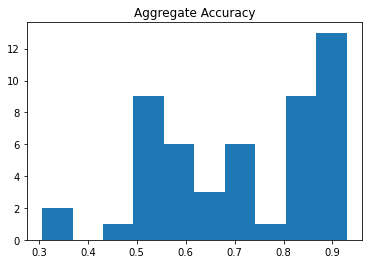

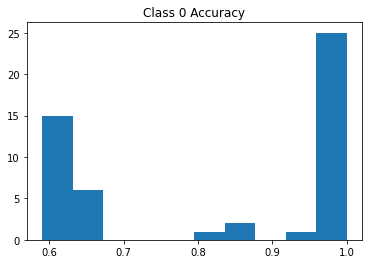

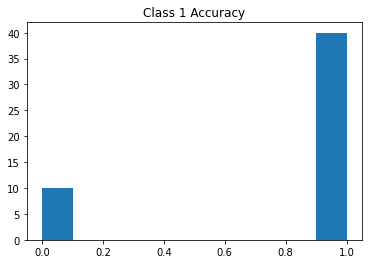

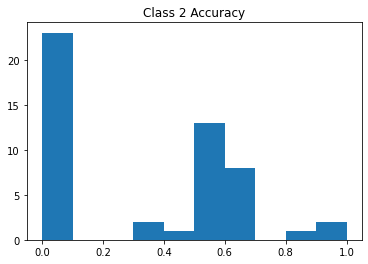

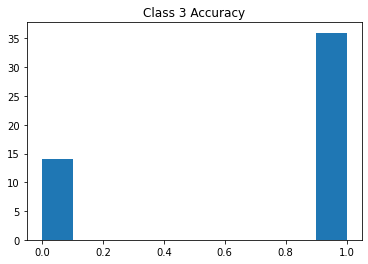

In [ ]:
plt.figure()
plt.hist(accs[:, 0])
plt.title("Aggregate Accuracy")
plt.show()

plt.figure()
plt.hist(accs[:, 1])
plt.title("Class 0 Accuracy")
plt.show()

plt.figure()
plt.hist(accs[:, 2])
plt.title("Class 1 Accuracy")
plt.show()

plt.figure()
plt.hist(accs[:, 3])
plt.title("Class 2 Accuracy")
plt.show()

plt.figure()
plt.hist(accs[:, 4])
plt.title("Class 3 Accuracy")
plt.show()